# Imports 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import functions as f

In [2]:
df = pd.read_csv('person_updated.csv')

## Conbining values for easier target varibale capture

In [3]:
df.person_injury_severity = df.person_injury_severity.str.lower()
df.loc[df['person_injury_severity'] == 'c - possible injury', 'person_injury_severity'] = 'b - suspected minor injury'
df.drop(df.loc[df['person_injury_severity'] == '99 - unknown'].index, inplace=True)

In [4]:
df.person_injury_severity.value_counts()

person_injury_severity
b - suspected minor injury      8521
a - suspected serious injury    4016
n - not injured                 1162
k - fatal injury                 849
Name: count, dtype: int64

# Preprocessing

In [5]:
df.head()

,person_age,person_gender,person_ethnicity,person_injury_severity,driver_license_class,motorcycle_endorsed
0,37,1 - MALE,W - WHITE,a - suspected serious injury,C - CLASS C,False
1,30,1 - MALE,H - HISPANIC,b - suspected minor injury,C - CLASS C,False
2,20,1 - MALE,W - WHITE,b - suspected minor injury,C - CLASS C,False
3,21,1 - MALE,W - WHITE,a - suspected serious injury,C - CLASS C,False
4,18,1 - MALE,H - HISPANIC,b - suspected minor injury,5 - UNLICENSED,False


    First I am going to convert non numerical values to numerical values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14548 entries, 0 to 14547
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   person_age              14548 non-null  int64 
 1   person_gender           14548 non-null  object
 2   person_ethnicity        14548 non-null  object
 3   person_injury_severity  14548 non-null  object
 4   driver_license_class    14548 non-null  object
 5   motorcycle_endorsed     14548 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 582.6+ KB


In [7]:
object_cols = []
encoded_df = df.copy()  
for col in df.columns:
    if df[col].dtype == 'object' and col != 'person_injury_severity':
        object_cols.append(col)
        dummies = pd.get_dummies(data=df[col], columns=[col], drop_first=True, prefix=col, dtype=int)
        encoded_df = pd.concat([encoded_df, dummies], axis=1)
        encoded_df.drop(col, axis=1, inplace=True)
encoded_df = encoded_df[[col for col in encoded_df.columns if col != 'person_injury_severity']]
encoded_df['person_injury_severity'] = df['person_injury_severity']

In [8]:
encoded_df.head()

,person_age,motorcycle_endorsed,person_gender_2 - FEMALE,person_ethnicity_A - ASIAN,person_ethnicity_B - BLACK,person_ethnicity_H - HISPANIC,person_ethnicity_I - AMER. INDIAN/ALASKAN NATIVE,person_ethnicity_W - WHITE,driver_license_class_98 - OTHER/OUT OF STATE,driver_license_class_A - CLASS A,driver_license_class_AM - CLASS A AND M,driver_license_class_B - CLASS B,driver_license_class_BM - CLASS B AND M,driver_license_class_C - CLASS C,driver_license_class_CM - CLASS C AND M,driver_license_class_M - CLASS M,person_injury_severity
0,37,False,0,0,0,0,0,1,0,0,0,0,0,1,0,0,a - suspected serious injury
1,30,False,0,0,0,1,0,0,0,0,0,0,0,1,0,0,b - suspected minor injury
2,20,False,0,0,0,0,0,1,0,0,0,0,0,1,0,0,b - suspected minor injury
3,21,False,0,0,0,0,0,1,0,0,0,0,0,1,0,0,a - suspected serious injury
4,18,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,b - suspected minor injury


     This seems to be end of our preproceessing part

# Splitting the data 

In [9]:
train, validate, test = f.split(encoded_df)

In [10]:
x_train = train.drop(columns= 'person_injury_severity')
y_train = train['person_injury_severity']

x_validate = validate.drop(columns= 'person_injury_severity')
y_validate = validate['person_injury_severity']

x_test= test.drop(columns= 'person_injury_severity')
y_test = test['person_injury_severity']

# Make our baseline model

In [11]:
df.person_injury_severity.value_counts()

person_injury_severity
b - suspected minor injury      8521
a - suspected serious injury    4016
n - not injured                 1162
k - fatal injury                 849
Name: count, dtype: int64

    Since suspected minor injury occurs most often this will be our baseline

In [12]:
pred_df_train = pd.DataFrame()
pred_df_train['actual'] = y_train

In [13]:
pred_df_train['baseline_predictions'] = 'b - suspected minor injury' 

In [14]:
pred_df_train['baseline_predictions']

6551     b - suspected minor injury
4889     b - suspected minor injury
2173     b - suspected minor injury
6022     b - suspected minor injury
3864     b - suspected minor injury
                    ...            
4393     b - suspected minor injury
6667     b - suspected minor injury
2912     b - suspected minor injury
3798     b - suspected minor injury
14295    b - suspected minor injury
Name: baseline_predictions, Length: 8146, dtype: object

In [15]:
pred_df_train.actual.value_counts()

actual
b - suspected minor injury      4778
a - suspected serious injury    2257
n - not injured                  648
k - fatal injury                 463
Name: count, dtype: int64

In [16]:
print(classification_report(pred_df_train['actual'],pred_df_train['baseline_predictions']))

                              precision    recall  f1-score   support

a - suspected serious injury       0.00      0.00      0.00      2257
  b - suspected minor injury       0.59      1.00      0.74      4778
            k - fatal injury       0.00      0.00      0.00       463
             n - not injured       0.00      0.00      0.00       648

                    accuracy                           0.59      8146
                   macro avg       0.15      0.25      0.18      8146
                weighted avg       0.34      0.59      0.43      8146



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Descion Tree Classifier:

### make the model

In [17]:
clf = DecisionTreeClassifier(max_depth= 5, random_state= 666)

### Fit the model 

In [18]:
clf.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=666)

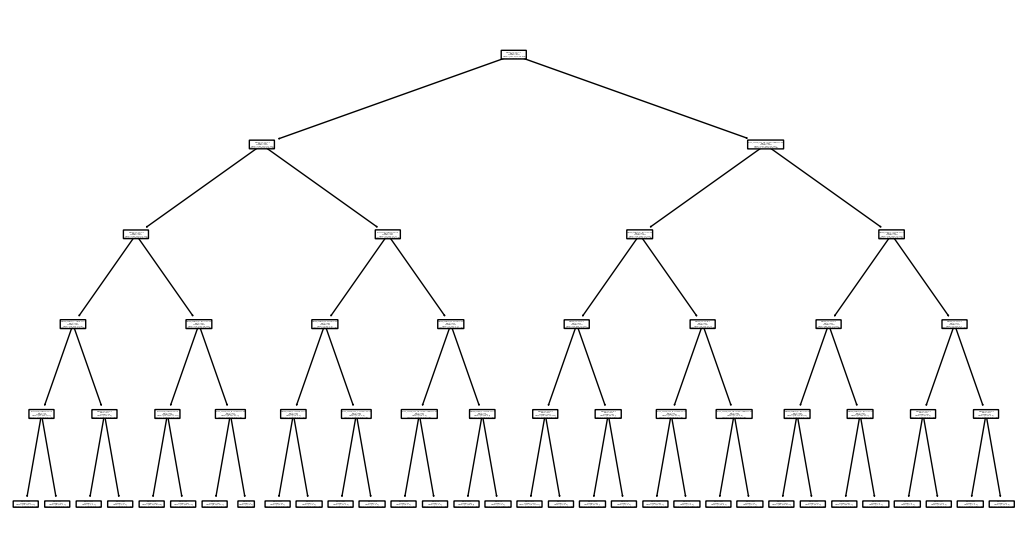

In [19]:
plt.figure(figsize=(13, 7))
plot_tree(clf, feature_names=x_train.columns, class_names=clf.classes_, rounded=True)
plt.show()

In [20]:
pred_df_train['clf_prediction'] = clf_pred = clf.predict(x_train)

In [21]:
pred_df_train

,actual,baseline_predictions,clf_prediction
6551,a - suspected serious injury,b - suspected minor injury,b - suspected minor injury
4889,b - suspected minor injury,b - suspected minor injury,b - suspected minor injury
2173,b - suspected minor injury,b - suspected minor injury,b - suspected minor injury
6022,b - suspected minor injury,b - suspected minor injury,b - suspected minor injury
3864,a - suspected serious injury,b - suspected minor injury,b - suspected minor injury
...,...,...,...
4393,a - suspected serious injury,b - suspected minor injury,b - suspected minor injury
6667,b - suspected minor injury,b - suspected minor injury,b - suspected minor injury
2912,b - suspected minor injury,b - suspected minor injury,b - suspected minor injury
3798,a - suspected serious injury,b - suspected minor injury,b - suspected minor injury


In [22]:
print(classification_report(pred_df_train.actual,pred_df_train.clf_prediction))

                              precision    recall  f1-score   support

a - suspected serious injury       0.50      0.05      0.09      2257
  b - suspected minor injury       0.59      0.98      0.74      4778
            k - fatal injury       0.00      0.00      0.00       463
             n - not injured       1.00      0.00      0.01       648

                    accuracy                           0.59      8146
                   macro avg       0.52      0.26      0.21      8146
                weighted avg       0.57      0.59      0.46      8146



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# KNN: 

In [23]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(x_train, y_train)
pred_df_train['knn'] = knn.predict(x_train)
print(classification_report(pred_df_train.actual,pred_df_train.knn))

                              precision    recall  f1-score   support

a - suspected serious injury       0.40      0.41      0.41      2257
  b - suspected minor injury       0.65      0.77      0.70      4778
            k - fatal injury       0.50      0.02      0.04       463
             n - not injured       0.33      0.03      0.06       648

                    accuracy                           0.57      8146
                   macro avg       0.47      0.31      0.30      8146
                weighted avg       0.54      0.57      0.53      8146



# Logistic Regression:

In [24]:
# First we get the weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# make the model
logit = LogisticRegression(C=1, class_weight=dict(zip(np.unique(y_train), class_weights)), random_state=666, intercept_scaling=1, solver='lbfgs')
# fit the model
logit.fit(x_train, y_train)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1,
                   class_weight={'a - suspected serious injury': 0.9023039432875498,
                                 'b - suspected minor injury': 0.4262243616575973,
                                 'k - fatal injury': 4.398488120950324,
                                 'n - not injured': 3.142746913580247},
                   random_state=666)

In [25]:
# check the intercepts and the coefficients of the logistic regression model
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)


Coefficient: 
 [[ 4.85136452e-03 -1.21646166e-01  2.76360948e-01  5.60853889e-02
  -1.26922818e-01 -1.23370933e-02 -5.35907984e-02  8.38476383e-02
  -1.36268123e-01 -4.08189189e-03  1.21194363e-01  1.03378473e-01
  -3.67355940e-02  2.37082731e-02 -3.54948856e-02 -1.70610050e-01]
 [-9.77346780e-03  7.10574758e-02  4.93613496e-01  3.53871000e-03
   1.10723634e-01  3.21290145e-02 -5.29549142e-02  5.93600009e-02
  -5.22051430e-02 -8.39290315e-02 -1.37749435e-01  1.12050334e-01
   1.01214419e-01 -3.52762478e-04  1.31328287e-01 -2.37357959e-02]
 [ 1.71961346e-02 -1.59993290e-01 -5.84484240e-01 -3.01636076e-02
  -1.74097705e-01 -1.65829666e-01  1.36850917e-02 -1.48547552e-01
  -3.72258780e-02  1.84606440e-01  1.73855986e-01 -1.14128126e-01
  -5.22731282e-02 -3.37609817e-02 -5.53012028e-02 -2.26274945e-01]
 [-1.22740313e-02  2.10581980e-01 -1.85490204e-01 -2.94604914e-02
   1.90296889e-01  1.46037745e-01  9.28606209e-02  5.33991257e-03
   2.25699144e-01 -9.65955161e-02 -1.57300914e-01 -1.01300

In [26]:
# make predictions 
pred_df_train['logistic'] = logit.predict(x_train)

In [27]:
print(classification_report(pred_df_train['actual'], pred_df_train['logistic']))

                              precision    recall  f1-score   support

a - suspected serious injury       0.33      0.17      0.22      2257
  b - suspected minor injury       0.65      0.24      0.35      4778
            k - fatal injury       0.08      0.47      0.14       463
             n - not injured       0.10      0.36      0.15       648

                    accuracy                           0.25      8146
                   macro avg       0.29      0.31      0.22      8146
                weighted avg       0.48      0.25      0.29      8146



In [28]:
for cols in pred_df_train.columns:
    if (pred_df_train[cols] != pred_df_train['actual']).any():
        print(f'classification report for {cols}:')
        print('=====================================')
        print(classification_report(pred_df_train['actual'], pred_df_train[cols]))
    else:
        print(f"The {cols} column matches the 'actual' column.")


The actual column matches the 'actual' column.
classification report for baseline_predictions:
                              precision    recall  f1-score   support

a - suspected serious injury       0.00      0.00      0.00      2257
  b - suspected minor injury       0.59      1.00      0.74      4778
            k - fatal injury       0.00      0.00      0.00       463
             n - not injured       0.00      0.00      0.00       648

                    accuracy                           0.59      8146
                   macro avg       0.15      0.25      0.18      8146
                weighted avg       0.34      0.59      0.43      8146

classification report for clf_prediction:


/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/l

                              precision    recall  f1-score   support

a - suspected serious injury       0.50      0.05      0.09      2257
  b - suspected minor injury       0.59      0.98      0.74      4778
            k - fatal injury       0.00      0.00      0.00       463
             n - not injured       1.00      0.00      0.01       648

                    accuracy                           0.59      8146
                   macro avg       0.52      0.26      0.21      8146
                weighted avg       0.57      0.59      0.46      8146

classification report for knn:
                              precision    recall  f1-score   support

a - suspected serious injury       0.40      0.41      0.41      2257
  b - suspected minor injury       0.65      0.77      0.70      4778
            k - fatal injury       0.50      0.02      0.04       463
             n - not injured       0.33      0.03      0.06       648

                    accuracy                          